In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn import model_selection
from sklearn import metrics 
from pandas import DataFrame
from matplotlib import pylab as plt

from copy import copy
import random
import sys
import time

In [2]:
# Загружаем набор данных Ирисы:
iris = datasets.load_iris()

iris_frame = DataFrame(iris.data)
iris_frame.columns = iris.feature_names
iris_frame['target'] = iris.target
iris_frame['name'] = iris_frame.target.apply(lambda x : iris.target_names[x])

iris_frame['petal_area'] = 0.0
for k in range(len(iris_frame['petal length (cm)'])):
    iris_frame['petal_area'][k] = iris_frame['petal length (cm)'][k] * iris_frame['petal width (cm)'][k]

# in data classes -> 1, 2, rename classes to 0, 1 in the same order
s1 = iris_frame[iris_frame['target'] == 2]
s1 = s1.replace(2, 1)
s2 = iris_frame[iris_frame['target'] == 1]
s2 = s2.replace(1, 0)
binary = pd.concat([s1, s2])

# new feature! we'll work with it... it splits the classes better
X_train, X_test, y_train, y_test = model_selection.train_test_split(binary[['petal length (cm)','petal_area']], 
                                                                                    binary[['target']], 
                                                                                    test_size = 0.3, 
                                                                                    random_state = 0)

/home/alexkay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Err in the beginning =  2347.39
Err became:	 2.897
final delt:	 0.0
iterations:	 356
weights is :  [1.3003420928926153, 1.3712653148254956]

 == EVALUATION == 


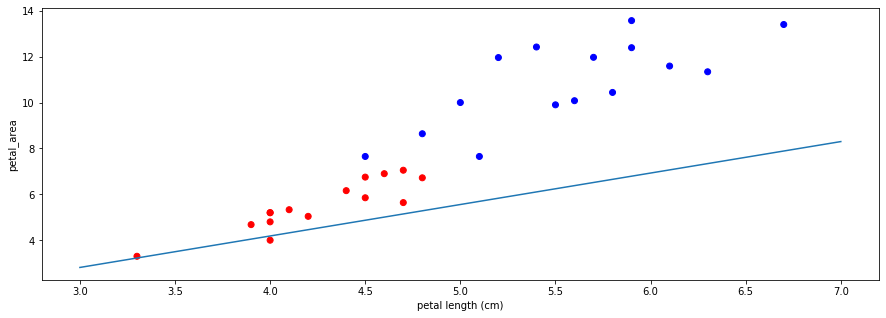

Prediction error =  0.644


In [6]:
class SGDClassifier:
    """
    No documentation
    """
    def __init__(self, rate=0.01, h=0.0001, eps=10e-8, dim=2, threshold=10e5):
        self.rate = rate
        self.h = h
        self.eps = eps
        self.dim = dim
        self.threshold = threshold
    
    def penalty_2D(self, real, pred, cl):
        """ 
        Penalty for mistakes 
        """
        if real > pred:
            cl_pred = 1
            return 0 if cl_pred == cl else abs(pred-real)
        elif real == pred:
            return 0
        else:
            cl_pred = 0
            return 0 if cl_pred == cl else abs(pred-real)
    
    def Job(self, X, Y, w):
        """ 
        Calculate whole error of classification
        """
        err = 0
        for i in range(len(X)):
            real = X[i][1]
            pred = X[i][0]*w[1] + w[0]
            cl = Y[i][0]
            err += self.penalty_2D(real, pred, cl)
        return err
    
    def SGD(self, X, Y):
        """
        SGD realisation
        """
        iterations = 0
        # start parameters
        w = [random.randint(0, 20) for i in range(self.dim)]
        was = self.Job(X, Y, w)
        print('Err in the beginning = ', was)
        
        # atributes
        eps = self.eps
        h = self.h
        rate = self.rate
        
        # init of vector
        w_new = [0, 0]

        while 1:
            if iterations%10 == 0:
                print(f"Iteration {iterations}", end="\r")
            iterations += 1

            i = random.randint(0, len(w)-1)
            
            # Adjust random weight
            w1 = copy(w)
            w1[i] = w1[i] - h
            w_new[i] = w[i] - rate * (1/h)*(self.Job(X,Y, w) - self.Job(X,Y,w1))
            w1 = copy(w)
            w = copy(w_new)
            
            became = self.Job(X,Y, w_new)
            delt = abs(became - was)
            if delt > eps: was = became
            else: break
            if iterations > (self.threshold):
                print('Something is going wrong... bruh')
                break

        print('Err became:\t',round(became,4))
        self.became = became
        delt = abs(became - was)
        print('final delt:\t', round(delt,4))
        print('iterations:\t', iterations)
        return w
    
    def fit(self, X, Y):
        X_train = np.array(X)
        y_train = np.array(Y)
        w = self.SGD(X_train, y_train)
        print('weights is : ', w)
        self.w = w
        return self.w
    
    def evaluate(self, X, Y):
        print()
        print(' == EVALUATION == ')
        from matplotlib.colors import ListedColormap
        x = np.linspace(3,7)
        X_test = np.array(X)
        y_test = np.array(Y)
        try:
            w = self.w
        except AttributeError:
            print('Action sequence error!')
            print('Please, make you sure model was fitted already')
            print('(Fit your model and repeat this part)')

        
        colors = ListedColormap(['red', 'green','blue'])
        fig = plt.figure(1, figsize=(15, 5))
        plt.scatter(X['petal length (cm)'], X['petal_area'], c=Y.iloc[:,0], cmap=colors)
        plt.ylabel('petal_area')
        plt.xlabel('petal length (cm)')
        plt.plot(x, [(w[1]*x-w[0]) for x in x])
        plt.show()
        
        error = self.Job(X_test, y_test, w)
        print('Prediction error = ', round(error, 3))
        return  error

        
if __name__ == "__main__":
    model = SGDClassifier(rate=0.01, h=0.5, eps=10e-8, threshold=10e06)
    model.fit(X_train, y_train)
    err = model.evaluate(X_test, y_test)